# Effect of straylight subtraction on MRS point source observations
The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.  
  
In this notebook we use the method of straylight subtraction (version 2) developed by Adrian Glauser and Polychronis Patapis at ETH Zurich (see MIRI-TN-00003-ETH-1.0_MRS_straylight). We check what the impact of the correction is on data of an 800K BB point source observed during testing carried out at RAL (MIRI FM test campaign).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

from numpy import (where,diff,meshgrid,arange,maximum,sqrt,zeros_like)
from astropy.convolution import convolve, Box2DKernel
from matplotlib import pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

We load an MRS image of a optical stimulus observed in one of the MRS nominal spectral bands. In this case the source is the:  
* MTS 800K BB point source, observed in spectral bands 1A/2A

In [2]:
# Define paths to data
workDir   = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir    = workDir+'cdp_data/'
d2cMapDir = workDir+'distortionMaps/'
lvl2path  = workDir+'FM_data/LVL2/'

# Get data
band     = '1A'
point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='middle',pointing='P1')

# load detector2cube (d2c) distortion maps
d2cMaps  = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta, and wavelength coordinates
sliceMap = d2cMaps['sliceMap']     # map with slice IDs
det_dims = (1024,1032)             # pixel dimensions of the detector

We subtract background exposures (if available).

In [3]:
point_source_bkgsubtr = point_source_sci-point_source_bkg

<IPython.core.display.Javascript object>


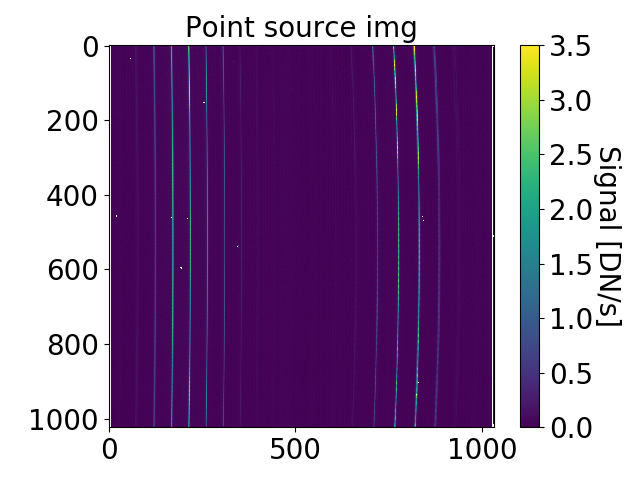

In [4]:
fig = plt.figure()
p = plt.imshow(point_source_bkgsubtr,vmin=0,vmax=3.5)
plt.title("Point source img")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

The straylight flux signal "s" in science pixels is inferred from the pixels $p_i$ in the low-signal space between the high-signal vertical slices. The straylight signal is inverse-distance weighted using Shepard's method (Shepard, Donald (1968), "A two-dimensional interpolation function for irregularly-spaced data", Proceedings of the 1968 ACM National Conference, pp. 517–524). Mathematically:  
$$  
s=\frac{\sum p_{i}\cdot w_{i}}{\sum w_i}  
$$
 
where the weight coefficients $w_i$ are given by  
$$
w_{i}=\left(\frac{max(0,R−d_{i})}{R\cdot d_{i}}\right)^k  
$$  
  
where $d_{i}$ is the distance to the science pixels within a radius of influence R. The exponent k is set equal to 1.

<IPython.core.display.Javascript object>


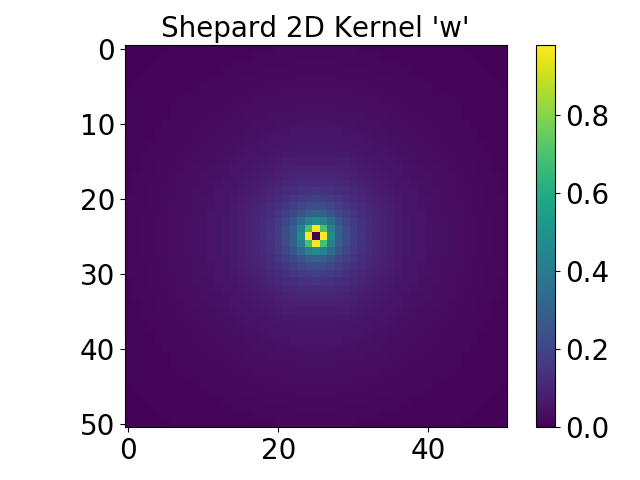

In [5]:
# Let's calculate the kernel matrix of Shepard's modified algorithm
#> the optimal parameters provided in MIRI-TN-00003-ETH-1.0_MRS_straylight (derived from a point source observation analysis) are:
R,k = 50,1

#> create the 2D kernel (w) of Shepard's algorithm is then calculated as:
xk, yk = meshgrid(arange(-R/2, R/2+1),arange(-R/2, R/2+1))
d = sqrt(xk**2+yk**2)
w = (maximum(0,R-d)/(R*d))**k
w[d==0]=0

#> we plot the result:
fig = plt.figure()
p   = plt.imshow(w)
fig.colorbar(p)
plt.title("Shepard 2D Kernel 'w'")
plt.tight_layout()

## Test 1: Calculate the amount of straylight

In [6]:
#>mask where gap pixels are 1 and slice pixels are 0
mask = zeros_like(sliceMap)
mask[sliceMap == 0] = 1

#>apply mask to science image
img_gap = point_source_bkgsubtr*mask

#> set pixels with signal less than zero to a signal of 0
img_gap[img_gap<0] = 0

#> smooth signal in gap pixels using a 2D box kernel of size 3
img_gap = convolve(img_gap, Box2DKernel(3))

#> reset sci pixels to 0
img_gap*=mask

#> convolve gap pixel img with weight kernel
straylight = convolve(img_gap, w)

#> normalize straylight flux by sum of weights
norm_conv = convolve(mask, w)
straylight /= norm_conv

In [7]:
test = point_source_bkgsubtr[512,:]
test_str = straylight[512,:]

<IPython.core.display.Javascript object>


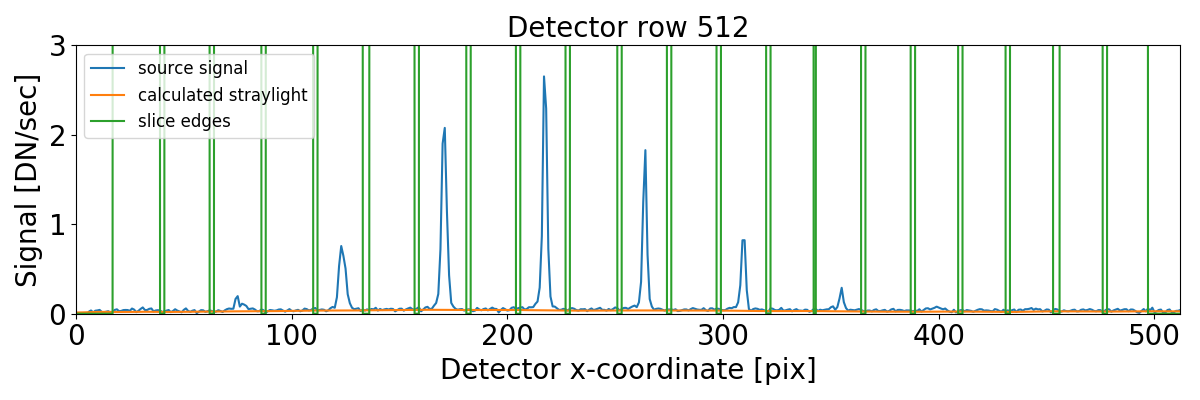

<IPython.core.display.Javascript object>


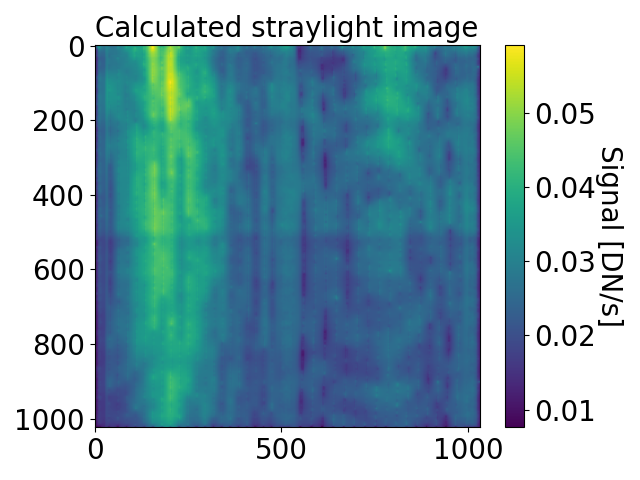

In [8]:
plt.figure(figsize=(12,4))
plt.title('Detector row 512')
plt.plot(point_source_bkgsubtr[512,:],label='source signal')
plt.plot(straylight[512,:],label='calculated straylight')
plt.plot(sliceMap[512,:],label='slice edges')
plt.xlim(0,512)
plt.ylim(0,3)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

fig = plt.figure()
p = plt.imshow(straylight,interpolation='None')
plt.title("Calculated straylight image")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

## Remarks:
* The computed straylight appears to have some structure in band 2A. The structure appears to be symmetric about row 512 (middle of the detector).
* There is a clear dark stripe (low-signal stripe) going through the row 512.
* Band 1A also has some higher-signal structure, that seems to follow the MRS slices. Can we "light this up" to better see what is happening?

## Test 2: What happens when the point is at the edge of a slice (i.e. at the edge of the MRS FOV)?

In [16]:
#> load and calibrate the data
point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='left',pointing='P10')
point_source_bkgsubtr = point_source_sci-point_source_bkg

w = funcs.Shepard2DKernel(R,k)
straylight = point_source_bkgsubtr-funcs.straylightCorrection(point_source_bkgsubtr,sliceMap,R=R, k=k)

<IPython.core.display.Javascript object>


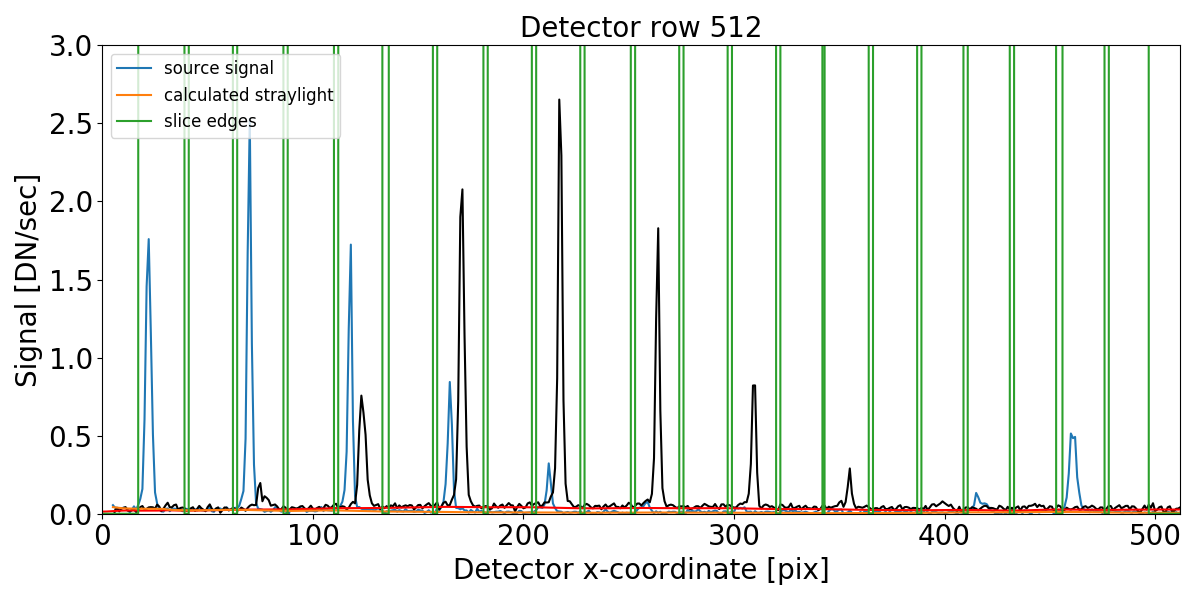

<IPython.core.display.Javascript object>


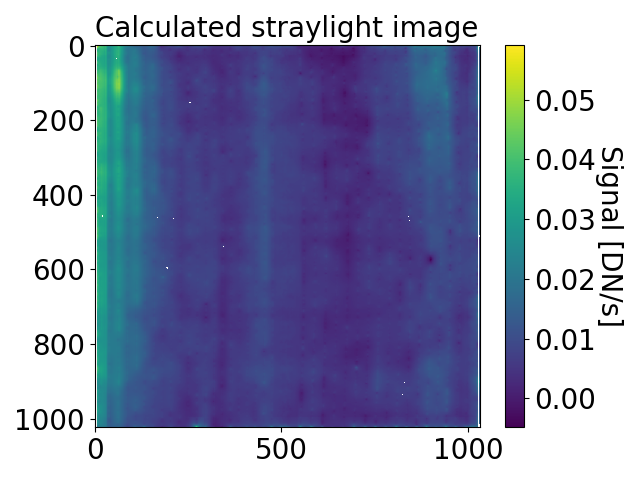

In [17]:
plt.figure(figsize=(12,6))
plt.title('Detector row 512')
plt.plot(point_source_bkgsubtr[512,:],label='source signal')
plt.plot(test,'k')
plt.plot(test_str,'r')
plt.plot(straylight[512,:],label='calculated straylight')
plt.plot(sliceMap[512,:],label='slice edges')
plt.xlim(0,512)
plt.ylim(0,3)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

fig = plt.figure()
p = plt.imshow(straylight,interpolation='None')
plt.title("Calculated straylight image")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

## Remarks:
* The computed straylight in band 1A appears to have structure. More importantly it appears that the structure is somehow related to the shape of the MRS slices.  
  
Let's overplot the slice map over the calculated straylight image.

<IPython.core.display.Javascript object>


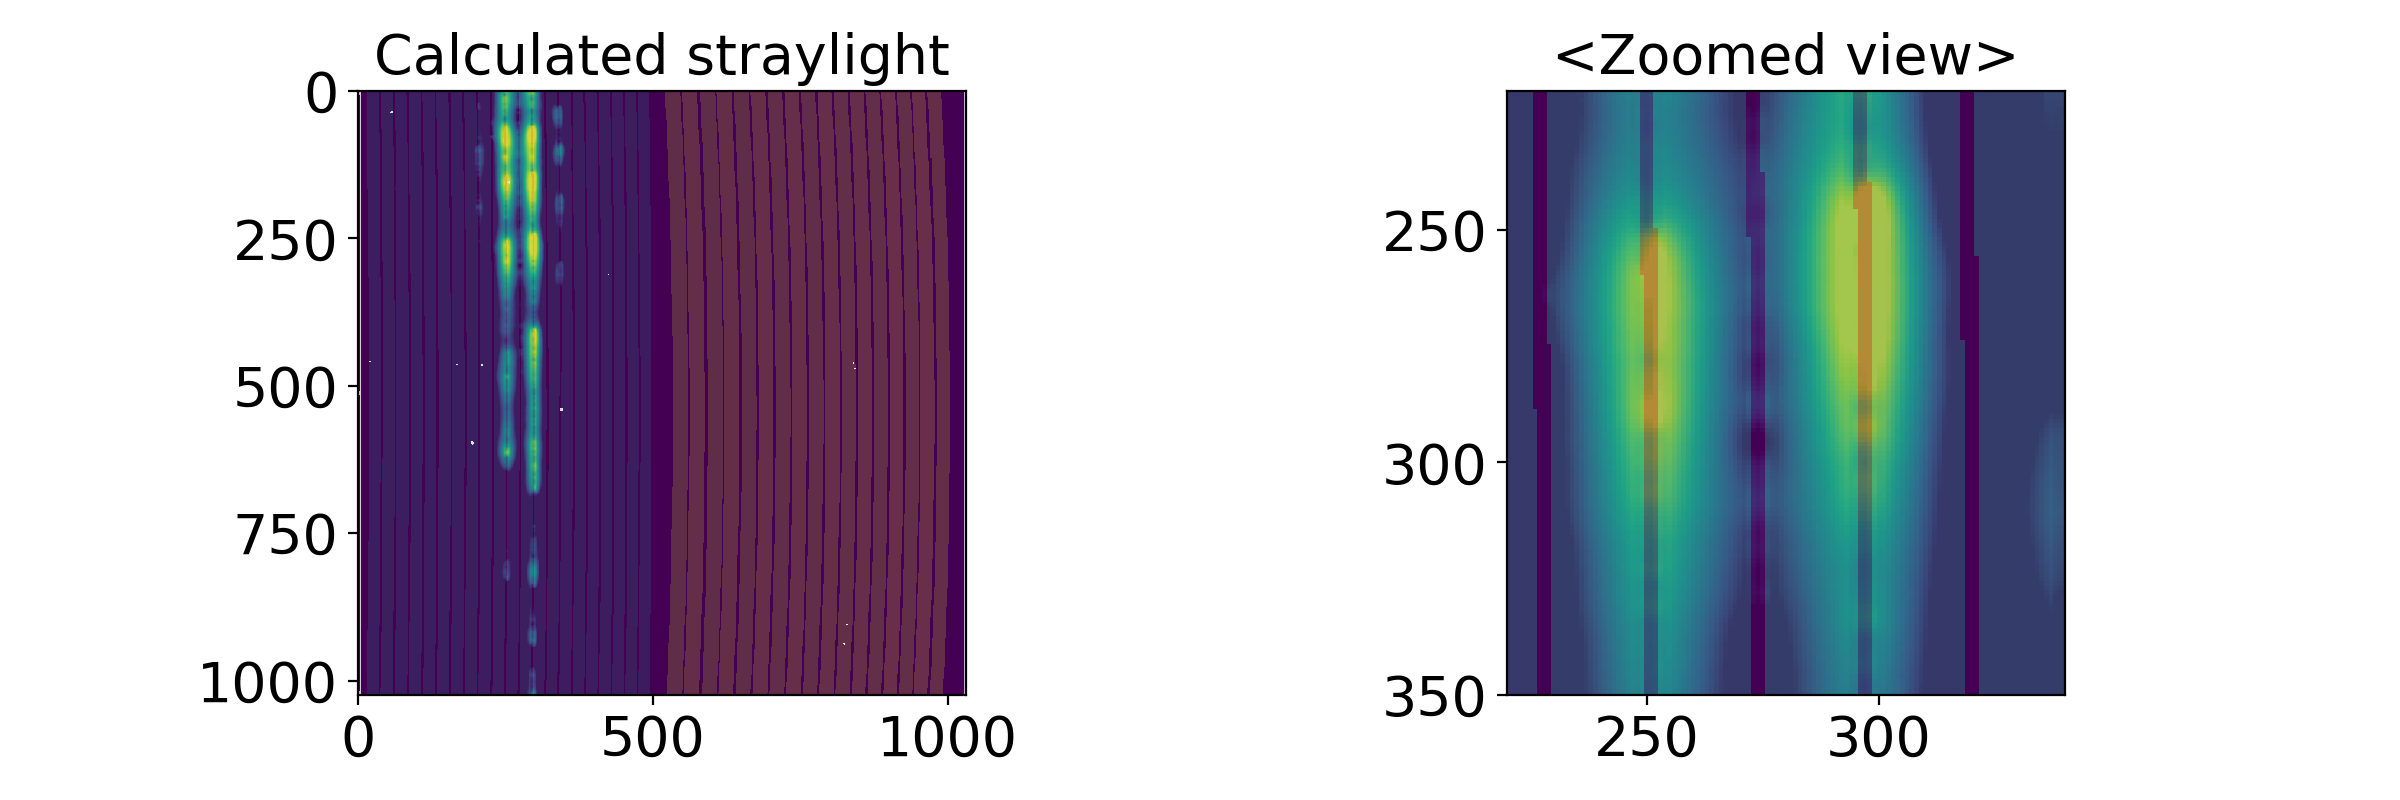

In [11]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].set_title("Calculated straylight")
axs[0].imshow(straylight,vmin=0.02,vmax=0.03,interpolation='None')
axs[0].imshow(sliceMap,alpha=0.2)
axs[1].set_title("<Zoomed view>")
axs[1].imshow(straylight,vmin=0.02,vmax=0.03,interpolation='None',zorder=0)
axs[1].imshow(sliceMap,alpha=0.4,zorder=1)
axs[1].set_xlim(220,340)
axs[1].set_ylim(350,220)
plt.tight_layout()

## Remarks:
* What exactly is happening? We see that, when close to a MRS slice corner (pixel column discontinuity), the estimated straylight signal is higher. Given that the straylight estimation algorithm uses the MRS d2c slice map, what we see actually makes sense. Pixels that have high signal, but which are omitted from being "science" pixels, amplify the estimation of the straylight. One could argue that this is correct, and that the straylight is genuinely higher at that location, however this can only be an erroneous conjecture. There is a clear link between what we measure, and the arbitrarily defined selection of which pixels count as science pixels and which count as non-science pixels.

## Test 3: What does the source spectrum look like in a detector pixel column that contains a pixel column discontinuity?

<IPython.core.display.Javascript object>


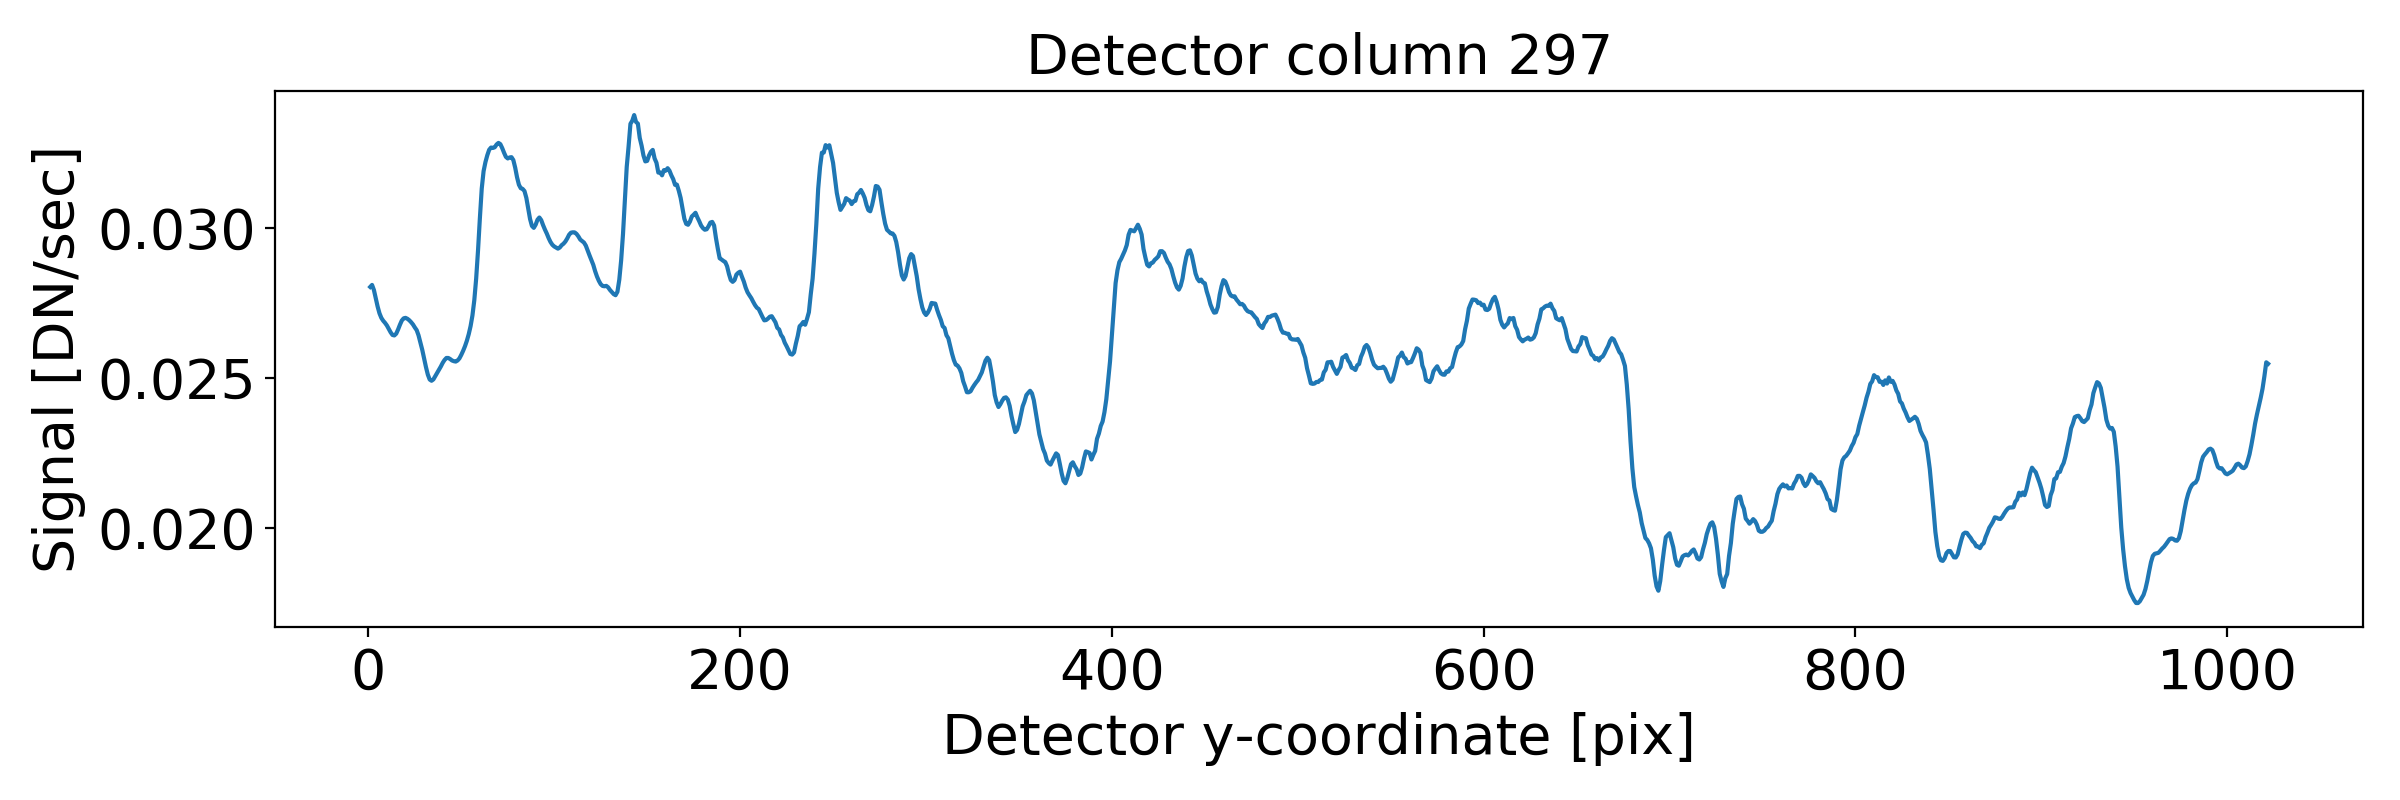

In [12]:
xcol = 297
plt.figure(figsize=(12,4))
plt.plot(straylight[:,xcol])
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title('Detector column {}'.format(xcol))
plt.tight_layout()

## Remark:
* There is a systematic under/over-estimation of the straylight caused by the definition of the d2c slice map (itself "burdened" by the pixel discretization of the MRS images).  
  
How does the above spectrum change within a slice? Let's look at pixel traces within a slice, at different (constant) along-slice positions $\alpha$.

<IPython.core.display.Javascript object>


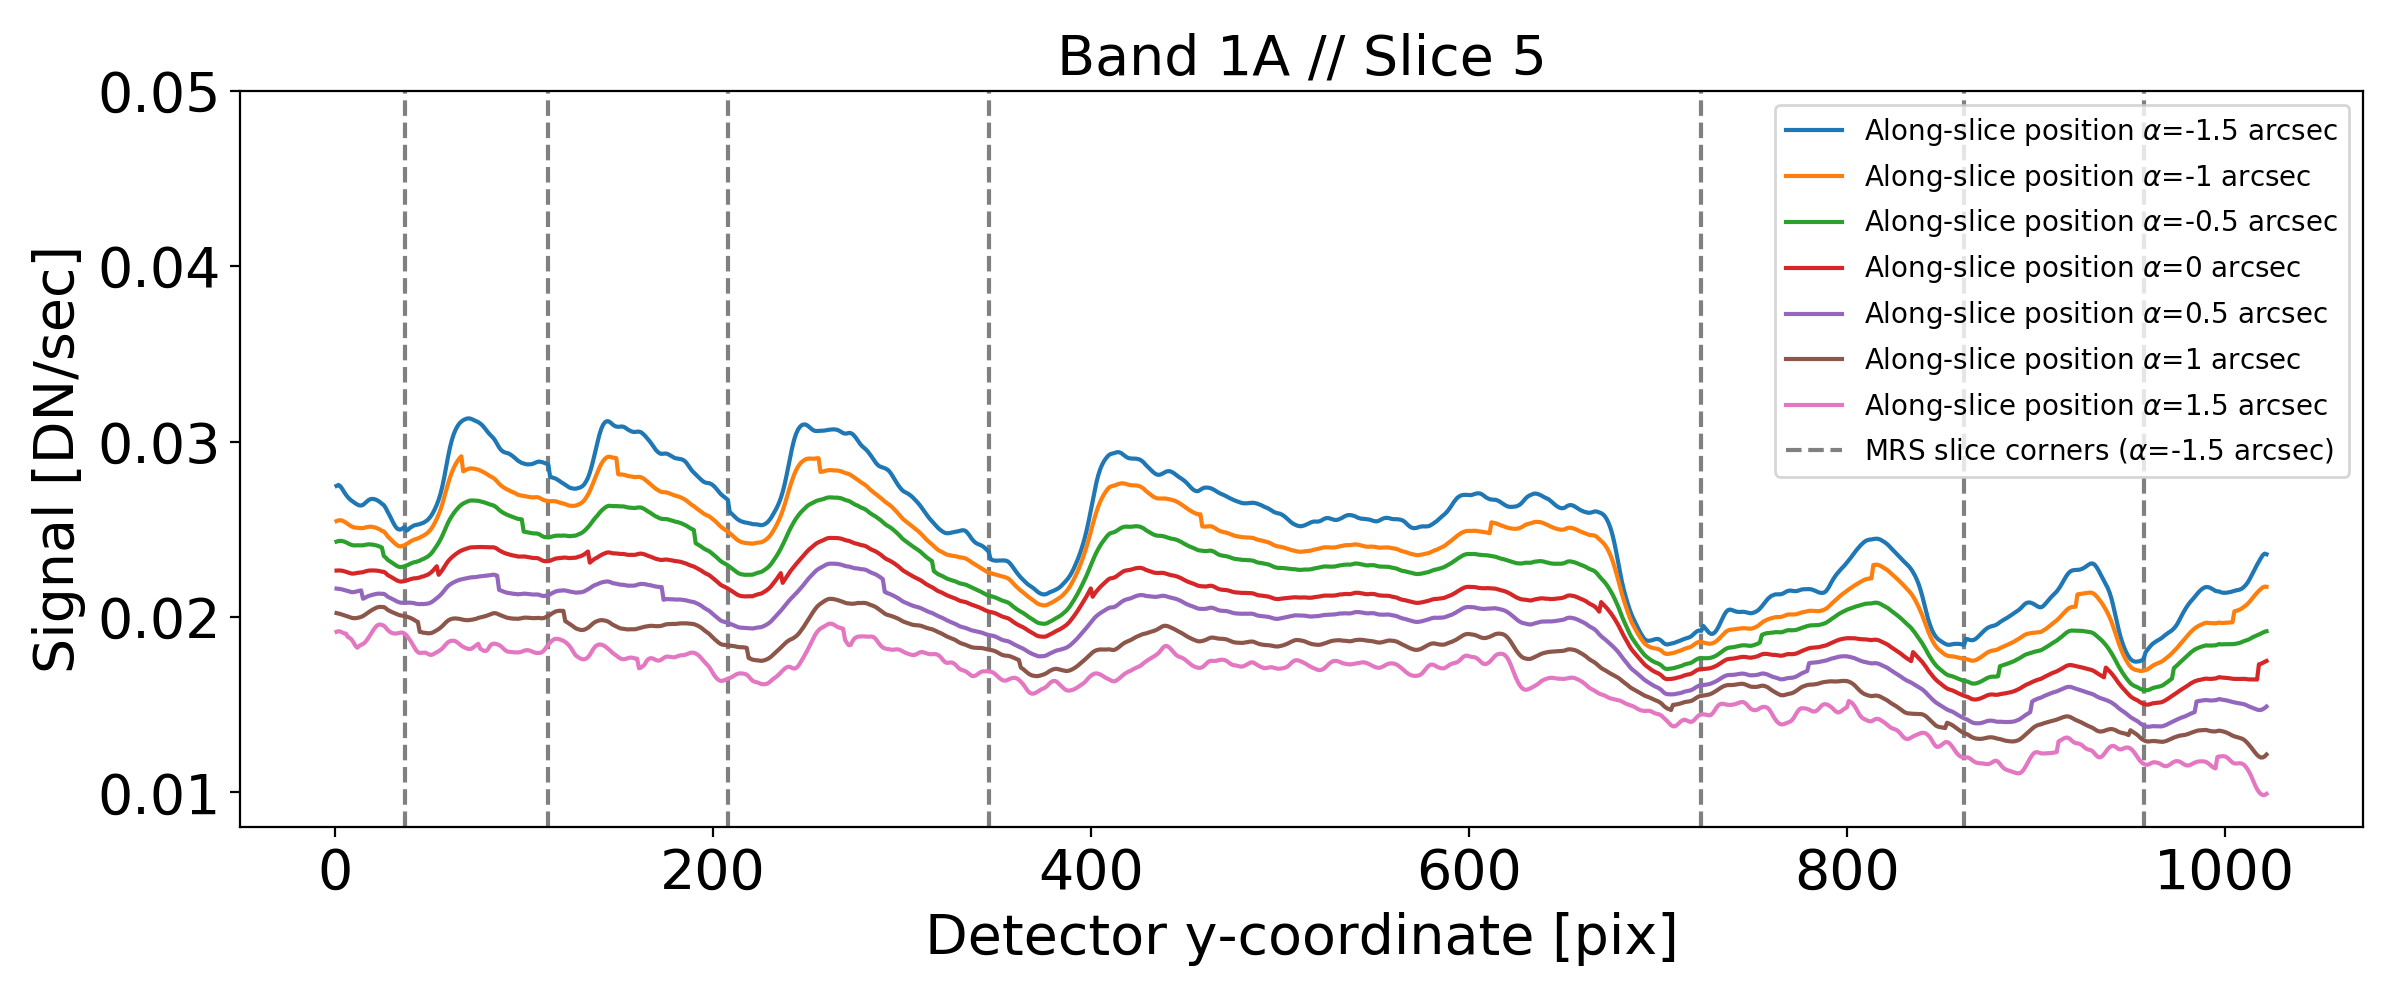

In [13]:
plt.figure(figsize=(12,5))
for alpha_pos in [-1.5,-1,-0.5,0,0.5,1,1.5]:
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=5,alpha_pos=alpha_pos)
    plt.plot(straylight[ypos,xpos],label=r'Along-slice position $\alpha$={} arcsec'.format(alpha_pos))
    if alpha_pos == -1.5:
        plt.vlines(where(abs(diff(xpos))==1),0.008,0.05,'gray',linestyle='dashed',label=r'MRS slice corners ($\alpha$={} arcsec)'.format(alpha_pos))
plt.ylim(0.008,0.05)
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.title('Band 1A // Slice 5')
plt.legend(loc='upper right',fontsize=10)
plt.tight_layout()

## Remarks:
* The straylight measure reduces the further one goes from (in this case) the left edge of the slice.
  
How does the straylight subtraction affect the scientific signal? Let's look at the ratio of the straylight signal and the scientific signal.

<IPython.core.display.Javascript object>


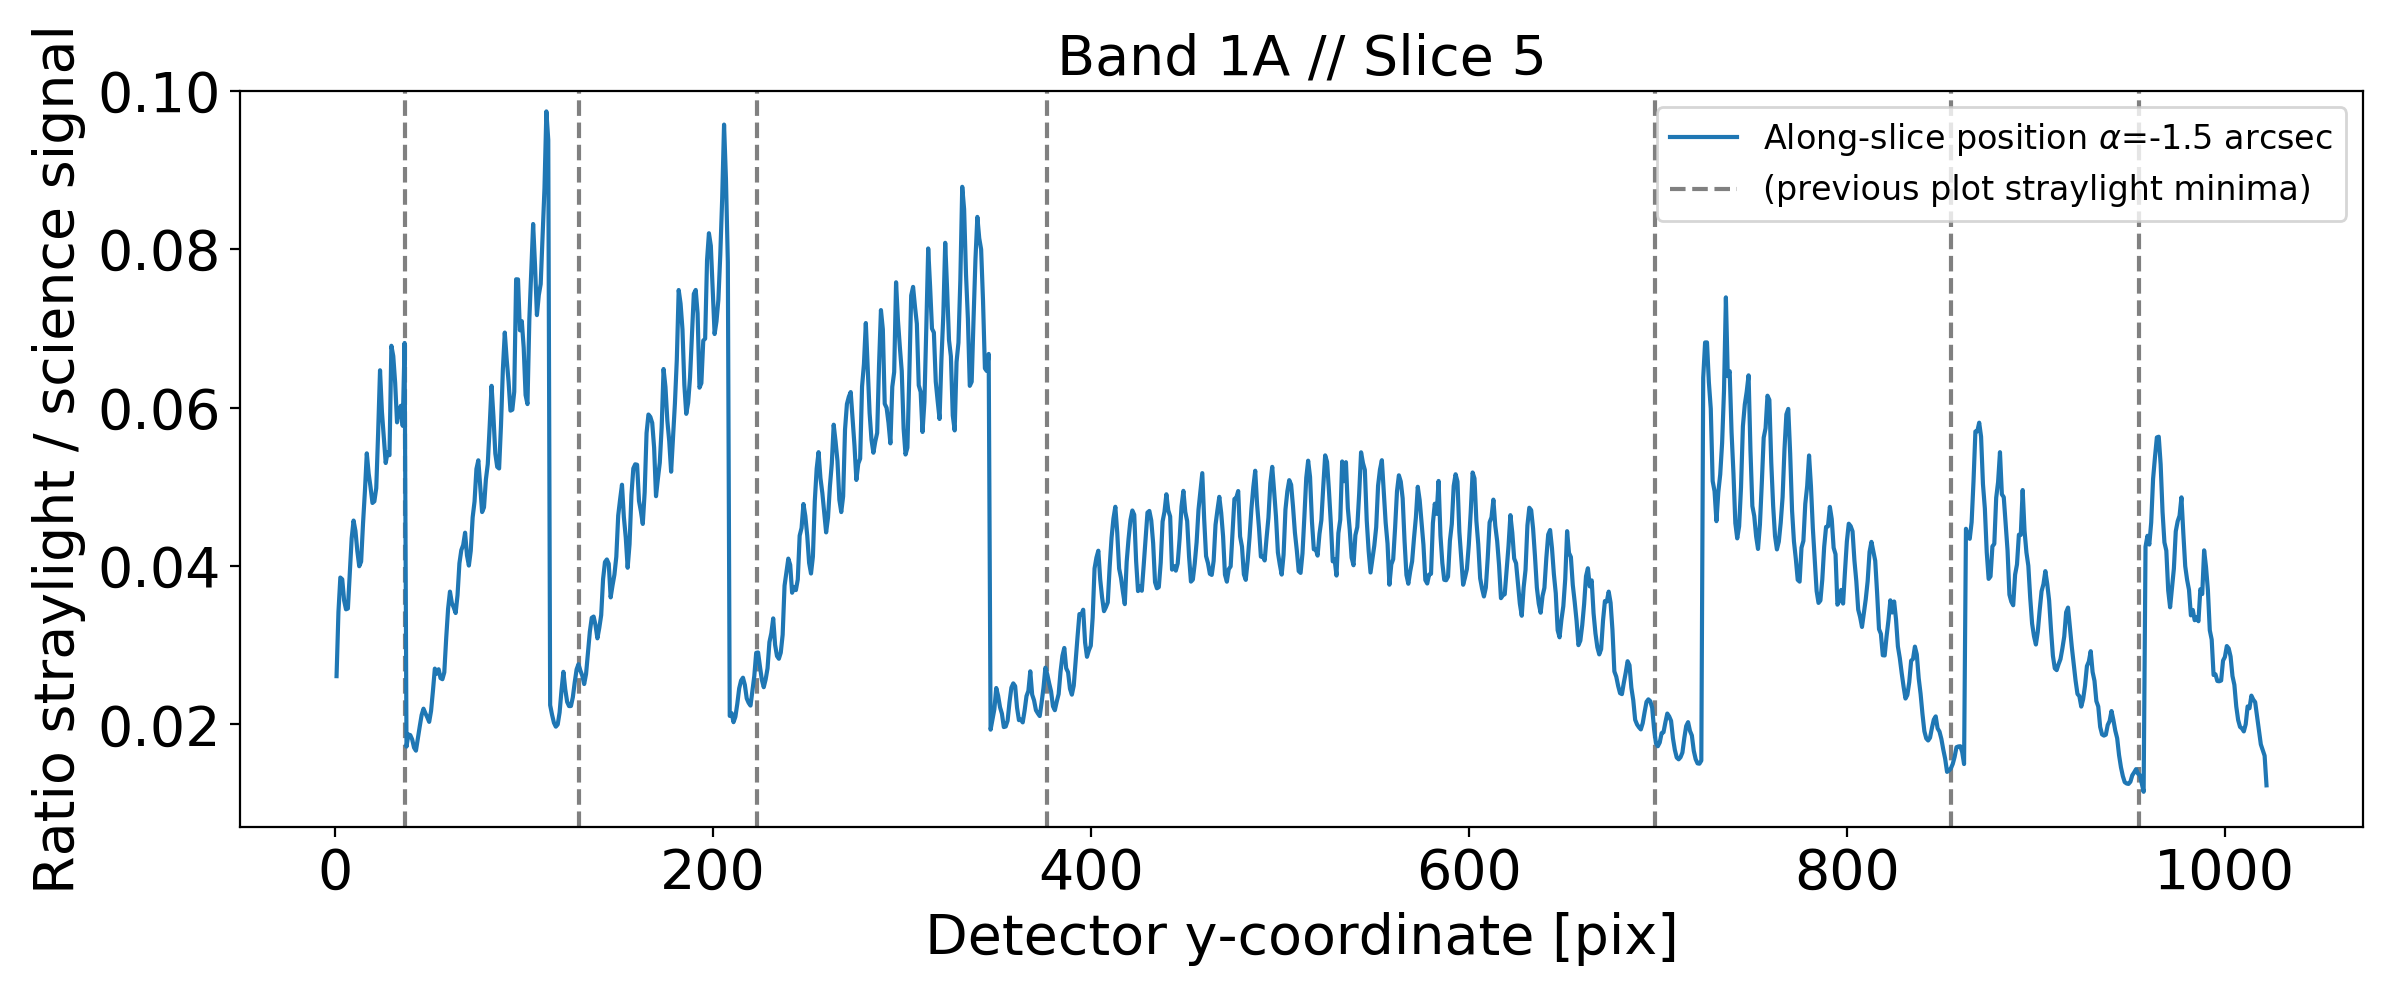

In [14]:
alpha_pos=-1.5
plt.figure(figsize=(12,5))
ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=5,alpha_pos=alpha_pos)
plt.plot(straylight[ypos,xpos]/point_source_bkgsubtr[ypos,xpos],label=r'Along-slice position $\alpha$={} arcsec'.format(alpha_pos))
plt.vlines([37.36,129.42,223.588,377,698.656,855.249,954.706],0.007,0.1,'gray',linestyle='dashed',label=r'(previous plot straylight minima)')
plt.ylim(0.007,0.1)
plt.xlabel('Detector y-coordinate [pix]')
plt.ylabel('Ratio straylight / science signal')
plt.title('Band 1A // Slice 5')
plt.legend(loc='upper right',fontsize=12)
plt.tight_layout()

## Remarks:
* Abrupt discontinuities in signal are caused by jumps between pixel columns. The PSF subsampling by the MRS is at the core of this phenomenon.
* In the worst case scenario, from peak to peak, there is a 6% difference in the above-plotted ratio.
* The MIRI MRS calibration procedure is bound to the hip with the fringing produced in the detector setup. The calculated straylight does not show fringing. This is both due to the fact that the straylight estimation algorithm cannot resolve high-frequency patterns, but also due to the fact that straylight is not expected to produce fringes. The reasoning behind the latter statement lies in the fact that straylight is expected to be "gray" (i.e. spectrally and spatially unresolved).  
  
Although the straylight does not seem to contain the signature of MIRI detector fringing, the systematic error in its determination does manifest as a low-frequency fluctuation in signal. One of the fringing components identified in the MRS spectra is a low-frequency fringe caused by internal reflection in one of the detector optical layers. How does the systematic error in the straylight affect the low-frequency fringe signature? (see Notebook 1)

In [13]:
#> load and calibrate the data
point_source_sci,point_source_bkg = mrsobs.FM_MTS_800K_BB_MRS_OPT_06_raster(lvl2path,position='right',pointing='P1')
point_source_bkgsubtr = point_source_sci-point_source_bkg

w = funcs.Shepard2DKernel(R,k)
straylight = point_source_bkgsubtr-funcs.straylightCorrection(point_source_bkgsubtr,sliceMap,R=R, k=k)

<IPython.core.display.Javascript object>


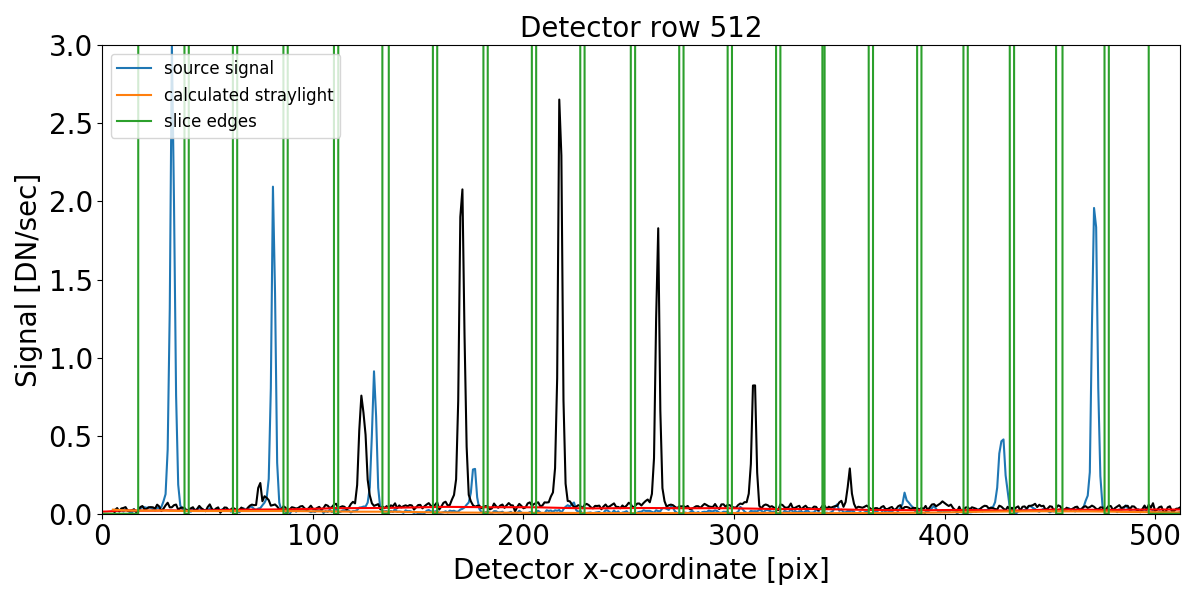

<IPython.core.display.Javascript object>


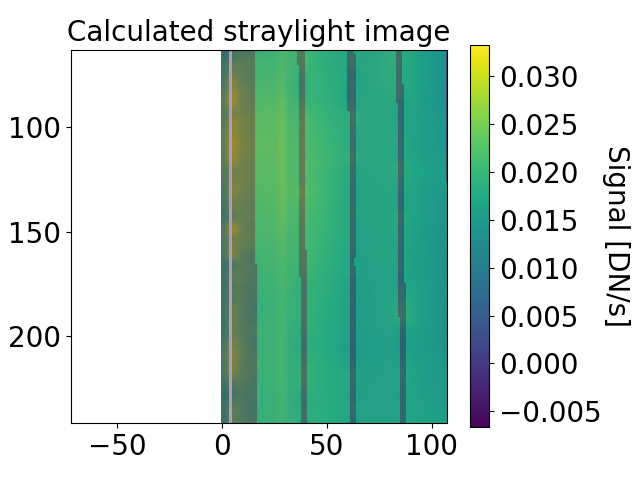

In [15]:
plt.figure(figsize=(12,6))
plt.title('Detector row 512')
plt.plot(point_source_bkgsubtr[512,:],label='source signal')
plt.plot(test,'k')
plt.plot(test_str,'r')
plt.plot(straylight[512,:],label='calculated straylight')
plt.plot(sliceMap[512,:],label='slice edges')
plt.xlim(0,512)
plt.ylim(0,3)
plt.xlabel('Detector x-coordinate [pix]')
plt.ylabel('Signal [DN/sec]')
plt.legend(loc='upper left',fontsize=12)
plt.tight_layout()

fig = plt.figure()
p = plt.imshow(straylight,interpolation='None')
plt.imshow(sliceMap,alpha=0.4)
plt.title("Calculated straylight image")
cbar = fig.colorbar(p)
cbar.set_label('Signal [DN/s]', labelpad=20,rotation=270)
plt.tight_layout()

# Conclusions:
* The third calibration step in the baseline MRS calibration pipeline (after assigning WCS information and applying the pixel flat), is the straylight subtraction. This step comes before the fringe correction and the flux calibration.
* Applying the current straylight algorithm (v2) yields a ratio between the scientific signal and the straylight signal of 5% (in MRS band 1A). Subtracting this "spurious" signal has an important impact on the scientific signal, and should thus be treated carefully.
* We notice that there is a systematic variation of the estimated straylight w.r.t. the detector2cube slice map. The cause is expected to be due to the selection of which detector pixels count as "science" pixels, and which count as "non-science" pixels. At locations where this distinction is not made carefully (due to the limitations imposed by the pixel discretization), the straylight signal is found to be larger than at other locations. This yields a systematic error w.r.t. the d2c slice map.
* The systematic error in the straylight determination propagates downward into the detector fringe correction and the flux calibration.

# Follow-up questions:
* What kind of "structure" does the straylight image measured in an extended source observation yield?